## 投票分类器

定义：聚合每个分类器的预测，将得票最多的结果作为最终的预测类别

如果满足以下条件，集成学习器将比最强的弱学习器还要更强
- 弱学习器完全独立
    - 如果不独立，多个弱学习器会犯同样的错误
    - 增强独立性的一种方法是采用不同的算法训练弱学习器
- 每个弱学习器比随机猜测更强

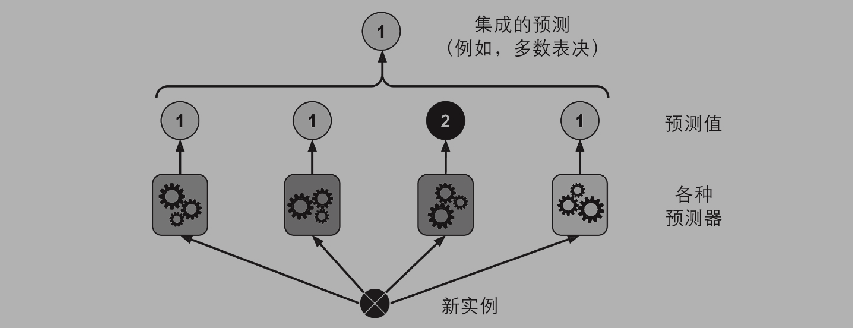

In [1]:
from IPython.display import Image
Image(filename = 'picture/voting_classifier.png')

In [2]:
# 卫星数据集
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


训练投票分类器，由三种不同的分类器组成
- 逻辑回归
- 随机森林
- 支持向量机

In [3]:
# 训练模型

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True))])

In [4]:
# 效果评估

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.864
RandomForestClassifier 0.904
SVC 0.896
VotingClassifier 0.904


- 硬投票：最终分类结果为最多弱学习器预测的结果
- 软投票：对于每个类别，对所有弱学习器预测的概率值作平均，最后选平均概率最大的类别

In [5]:
# 软投票
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf_soft.fit(X_train, y_train)
voting_clf_soft_y_pred = voting_clf_soft.predict(X_test)
print("voting_clf_soft", accuracy_score(y_test, voting_clf_soft_y_pred))

voting_clf_soft 0.904


## bagging和pasting
相同点：弱学习器采用相同的算法，但是在不同训练集的随机子集上训练

不同点：
- bagging：采样时将样本放回
- pasting：采样时样本不放回

sk-learn可用BaggingClassifier类进行bagging和pasting

In [6]:
# 500个决策树进行集成
# 每个决策树从训练集中随机采样100条样本进行训练
# bootstrap=True为有放回采样
# n_jobs=-1可使用所有CPU内核
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
bag_clf_y_pred = bag_clf.predict(X_test)
print("bag_clf", accuracy_score(y_test, bag_clf_y_pred))

bag_clf 0.92


### 包外评估
对于bagging，有些样本会被采样多次，有些则不会被采样到
若样本集大小为m，进行m次有放回采样，大约只有63%的样本会被采样到，剩下37%的样本为包外样本
包外评估：通过平均每个预测器的oob准确率评估来评估整体准确率

In [7]:
# 包外评估弱学习器平均准确率
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [8]:
# 测试集评估随机森林准确率
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.904

## 随机森林
除了使用BaggingClassifier构建随机森林，更好的方式是使用RandomForestClassifier或RandomForestRegressor
（这两种方法对决策树进行了优化）

随机森林在树的生长上引入了更多的随机性：分裂节点时不再是搜索最好的特征，而是在一个随机生成的特征子集里搜索最好的特征。这导致决策树具有更大的多样性，（再一次）用更高的偏差换取更低的方差，总之，还是产生了一个整体性能更优的模型

In [9]:
from sklearn.ensemble import RandomForestClassifier

# 方式一：
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
# 方式二：
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

随机森林的另一个好特性是它们使测量每个特征的相对重要性变得容易。Scikit-Learn通过查看使用该特征的树节点平均（在森林中的所有树上）减少不纯度的程度来衡量该特征的重要性

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.098554292487929
sepal width (cm) 0.027537830052573157
petal length (cm) 0.4419870786153643
petal width (cm) 0.43192079884413354


可以看出，花瓣长度（0.45）与花瓣宽度（0.43）最重要，花萼长度（0.09）与花萼宽度（0.02）不重要

## boosting
提升法（boosting）是循环训练预测器，每一次对前序学习器进行改进
### AdaBoost
该算法首先设置所有样本权重为1/m，训练第一个基础分类器（例如决策树），并使用它对训练集进行预测。然后，该算法会增加分类错误的训练实例的相对权重。然后，它使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新实例权重，以此类推

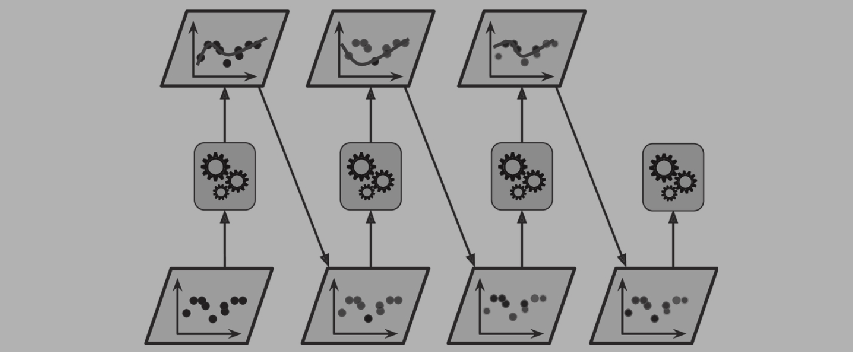

In [11]:
from IPython.display import Image
Image(filename = 'picture/AdaBoost.png')

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)

### 梯度提升
梯度提升是另一种提升方法，与adaboost不同的是：

梯度提升不像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对前一个预测器的残差进行拟合

实现一个梯度提升回归树：

In [13]:
# 方式一：自己手动实现

from sklearn.tree import DecisionTreeRegressor
# 在训练集（比如带噪声的二次训练集）上训练第一个树
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X_train, y_train)
# 针对第一个预测器的残差，训练第二个树
y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X_train, y2)
# 针对第二个预测器的残差，训练第三个树
y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X_train, y3)
# 将所有树的预测相加，从而对新实例进行预测
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([ 8.85063348e-01,  9.34252162e-02,  9.34252162e-02,  1.00009303e+00,
        1.10086754e+00,  8.85063348e-01,  5.20417043e-18,  9.34252162e-02,
        3.30225317e-02,  9.34252162e-02,  1.00009303e+00,  5.20417043e-18,
        8.85063348e-01,  6.24947209e-01,  9.51002935e-01,  5.20417043e-18,
        5.20417043e-18,  9.51002935e-01,  9.51002935e-01,  9.34252162e-02,
        5.20417043e-18,  1.09896212e+00,  8.85063348e-01,  3.30225317e-02,
        9.34252162e-02,  9.34252162e-02,  8.85063348e-01,  5.20417043e-18,
        9.51002935e-01,  5.20417043e-18,  9.51002935e-01,  1.00009303e+00,
       -1.66690923e-01,  5.20417043e-18,  8.40751403e-01,  6.24947209e-01,
        9.34252162e-02,  8.40751403e-01,  8.40751403e-01,  9.51002935e-01,
        1.59364803e-01,  8.85063348e-01,  6.24947209e-01,  9.34252162e-02,
        5.20417043e-18,  9.34252162e-02,  6.24947209e-01,  8.85063348e-01,
        1.10086754e+00,  8.85063348e-01,  8.85063348e-01,  1.00009303e+00,
        5.20417043e-18,  

In [14]:
# 方式二：直接使用GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
y_pred

array([ 8.85063348e-01,  9.34252162e-02,  9.34252162e-02,  1.00009303e+00,
        1.10086754e+00,  8.85063348e-01, -1.30104261e-17,  9.34252162e-02,
        3.30225317e-02,  9.34252162e-02,  1.00009303e+00, -1.30104261e-17,
        8.85063348e-01,  6.24947209e-01,  9.51002935e-01, -1.30104261e-17,
       -1.30104261e-17,  9.51002935e-01,  9.51002935e-01,  9.34252162e-02,
       -1.30104261e-17,  1.09896212e+00,  8.85063348e-01,  3.30225317e-02,
        9.34252162e-02,  9.34252162e-02,  8.85063348e-01, -1.30104261e-17,
        9.51002935e-01, -1.30104261e-17,  9.51002935e-01,  1.00009303e+00,
       -1.66690923e-01, -1.30104261e-17,  8.40751403e-01,  6.24947209e-01,
        9.34252162e-02,  8.40751403e-01,  8.40751403e-01,  9.51002935e-01,
        1.59364803e-01,  8.85063348e-01,  6.24947209e-01,  9.34252162e-02,
       -1.30104261e-17,  9.34252162e-02,  6.24947209e-01,  8.85063348e-01,
        1.10086754e+00,  8.85063348e-01,  8.85063348e-01,  1.00009303e+00,
       -1.30104261e-17, -

对于提升法，学习器太少可能欠拟合，过多可能过拟合（如下图所示）。
因此找到合适的弱学习器数量至关重要

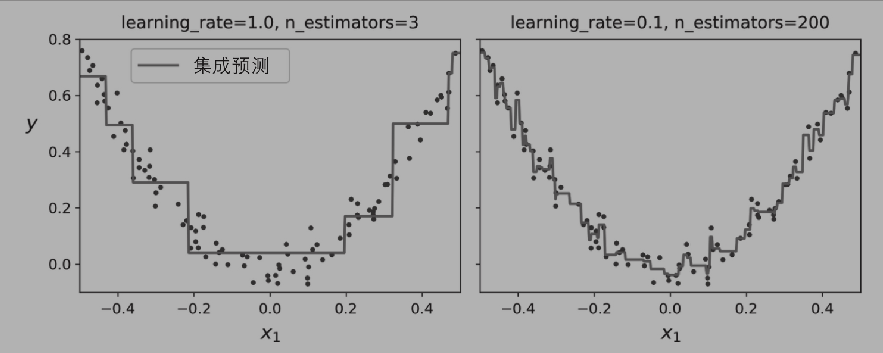

In [15]:
from IPython.display import Image
Image(filename = 'picture/gbdt.png')

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# 使用staged_predict()方法在训练的每个阶段（1棵树、2棵树...）返回一个集成学习器
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

min_error = np.min(errors)
min_error

0.002712853325235463

In [17]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

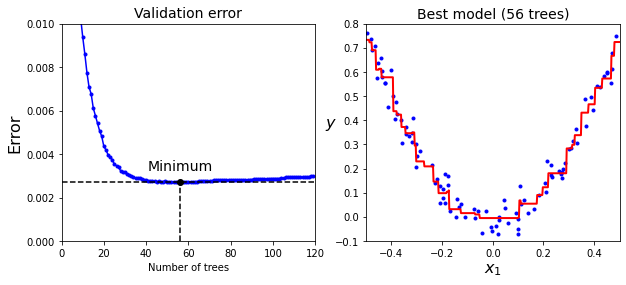

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

由此可以看出最佳子树数量及其误差的情况

### XGBoost（Extreme Gradient Boosting）
XGBoost是梯度提升的一种优化版本
- 显式地将树模型的复杂度作为正则项加在优化目标
- 将特征列排序后以block的形式存储在内存中，方便并行计算
- 引进了特征子采样，像RandomForest那样，这种方法既能降低过拟合，还能减少计算
- 自动处理提前停止
